In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

import esda
from libpysal.weights import KNN, lag_spatial
from splot.libpysal import plot_spatial_weights

/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/dmitri/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationW

General variables and dictionaries

In [2]:
VARIABLE = 'MonthlyIncome'
VARIABLE2 = 'Monthly income'

PREDICTOR = 'YearsOfEducation'
PREDICTOR2 = 'Years of education'

KNN_PARAM = 5
ALPHA_LEVEL = 0.05

J = 6 # Number of regions

---

Read the data and give it the basic needed structure

In [3]:
DatNational = pd.read_csv("../../../Data/Processed/DataNational.csv")

In [4]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
Dat = Dat[['ProvinceId', VARIABLE + 'Mean', PREDICTOR]]
Dat = Dat.sort_values('ProvinceId').reset_index(drop=True)

In [5]:
ThailandMap = gpd.read_file("../../../Data/Enriched/ThailandMapProvinceIdRegion/ThailandMapProvinceIdRegion.shp")
ThailandMap = ThailandMap.rename(columns={'RegionInTh':'RegionInThai'})

ThailandMap = ThailandMap.sort_values('ProvinceId').reset_index(drop=True)

ThailandMapWithoutBkk = ThailandMap[ThailandMap['Name']!='Bangkok'].reset_index(drop=True)
ThailandMap = pd.concat([ThailandMapWithoutBkk, ThailandMap[ThailandMap['Name']=='Bangkok']]).reset_index(drop=True)

---

Fit the spatial regression model

In [6]:
g_y = Dat[VARIABLE + 'Mean'].values.reshape(-1,1)
g_x = (Dat[PREDICTOR].values - DatNational['NationalYearsOfEducation'].values[0]).reshape(-1,1)
g_coords = [(x,y) for x,y in zip(ThailandMapWithoutBkk.centroid.x, ThailandMapWithoutBkk.centroid.y)]

/tmp/ipykernel_12622/266815834.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g_coords = [(x,y) for x,y in zip(ThailandMapWithoutBkk.centroid.x, ThailandMapWithoutBkk.centroid.y)]


In [7]:
gwr_selector = Sel_BW(g_coords, g_y, g_x)
gwr_bw = gwr_selector.search(bw_min=2)

In [8]:
model = GWR(g_coords, g_y, g_x, gwr_bw)
gwr_results = model.fit()

In [9]:
gwr_filtered_t = gwr_results.filter_tvals()

---

Create the maps

In [10]:
ThailandMapWithoutBkk[PREDICTOR] = Dat[PREDICTOR]
ThailandMapWithoutBkk[VARIABLE + 'MeanPredicted'] = gwr_results.params[:,0] + gwr_results.params[:,1] * (Dat[PREDICTOR] - DatNational['NationalYearsOfEducation'].values[0])
ThailandMapWithoutBkk[VARIABLE + 'Mean'] = Dat[VARIABLE + 'Mean']

ThailandMapWithoutBkk['Residual'] = ThailandMapWithoutBkk[VARIABLE + 'MeanPredicted'] - ThailandMapWithoutBkk[VARIABLE + 'Mean']

ThailandMapWithoutBkk['Slope'] = gwr_results.params[:,1]
ThailandMapWithoutBkk['SignificantSlope'] = gwr_filtered_t[:,1]

In [11]:
ThailandMap = pd.merge(
    ThailandMap
    , ThailandMapWithoutBkk[['ProvinceId', PREDICTOR, VARIABLE + 'Mean', VARIABLE + 'MeanPredicted', 'Slope', 'SignificantSlope']]
    , how='left'
)

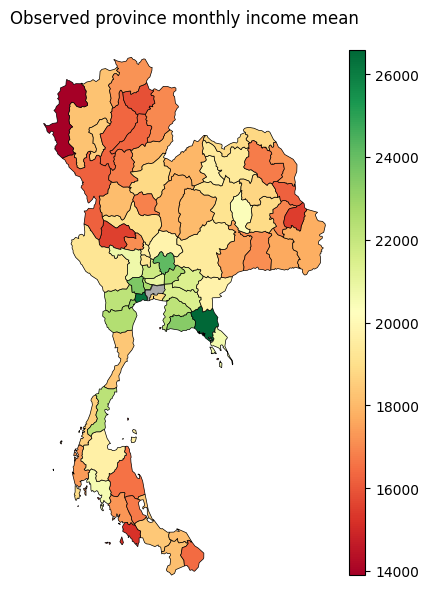

In [12]:
fig, ax = plt.subplots(figsize=(4,7.5))

ThailandMap.plot(
    VARIABLE + 'Mean'
    , ax = ax
    , cmap = 'RdYlGn'
    , edgecolor = 'k'
    , missing_kwds = {'color':'darkgrey', 'label':'No data'}
    , linewidth=0.5
).set_axis_off()

ax.set_title('Observed province monthly income mean')

cbar = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=ThailandMap[VARIABLE + 'Mean'].min(), vmax=ThailandMap[VARIABLE + 'Mean'].max()))
cb_ax = fig.add_axes([0.925,0.15,0.04,0.7])
fig.colorbar(cbar, cax=cb_ax, orientation="vertical")

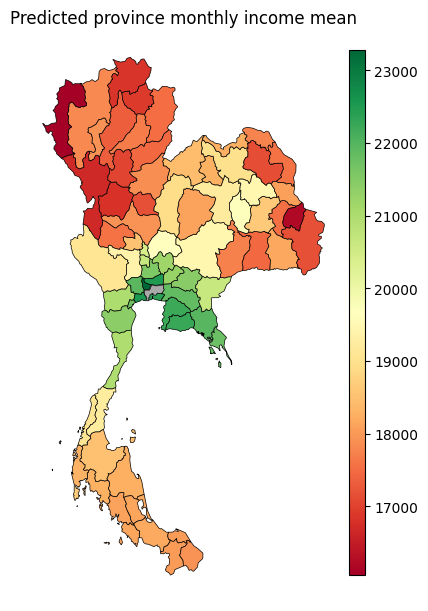

In [13]:
fig, ax = plt.subplots(figsize=(4,7.5))

ThailandMap.plot(
    VARIABLE + 'MeanPredicted'
    , ax = ax
    , cmap = 'RdYlGn'
    , edgecolor = 'k'
    , missing_kwds = {'color':'darkgrey', 'label':'No data'}
    , linewidth=0.5,  # Borderline width
).set_axis_off()

ax.set_title('Predicted province monthly income mean')

cbar = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=ThailandMap[VARIABLE + 'MeanPredicted'].min(), vmax=ThailandMap[VARIABLE + 'MeanPredicted'].max()))
cb_ax = fig.add_axes([0.925,0.15,0.04,0.7])
fig.colorbar(cbar, cax=cb_ax, orientation="vertical")

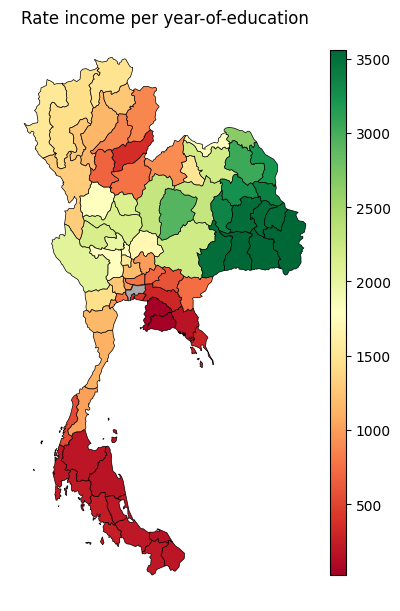

In [14]:
fig, ax = plt.subplots(figsize=(4,7.5))

ThailandMap.plot(
    'Slope'
    , ax = ax
    , cmap = 'RdYlGn'
    , edgecolor = 'k'
    , missing_kwds = {'color':'darkgrey', 'label':'No data'}
    , linewidth=0.5,  # Borderline width
).set_axis_off()

ax.set_title('Rate income per year-of-education')

cbar = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=ThailandMap['Slope'].min(), vmax=ThailandMap['Slope'].max()))
cb_ax = fig.add_axes([0.925,0.15,0.04,0.7])
fig.colorbar(cbar, cax=cb_ax, orientation="vertical")

In [15]:
if False:
    fig, ax = plt.subplots(figsize=(4,7.5))

    ThailandMap.plot(
        'Slope'
        , ax = ax
        , cmap = 'RdYlGn'
        , edgecolor = 'k'
        , missing_kwds = {'color':'darkgrey', 'label':'No data'}
        , linewidth=0.5,  # Borderline width
    ).set_axis_off()

    ThailandMap[ThailandMap['SignificantSlope'] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'}, linewidth=0.5)

    ax.set_title('Rate income per year-of-education')

    cb_ax = fig.add_axes([0.925,0.15,0.04,0.7])
    fig.colorbar(cbar, cax=cb_ax, orientation="vertical")

---

## Evaluate the spatial structure of the residuals

Calculate the spatial weights

In [16]:
WeightKnn = KNN.from_dataframe(ThailandMapWithoutBkk, k=KNN_PARAM)
WeightKnn.transform = 'R'

Calculate the spatial lag

In [17]:
ThailandMapWithoutBkk['ResidualSpatialLag'] = lag_spatial(WeightKnn, ThailandMapWithoutBkk['Residual'])

ThailandMap = pd.merge(
    ThailandMap
    , ThailandMapWithoutBkk[['ProvinceId', 'Residual', 'ResidualSpatialLag']]
    , how='left'
)

/home/dmitri/.local/lib/python3.11/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/home/dmitri/.local/lib/python3.11/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)
/tmp/ipykernel_12622/3429062143.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


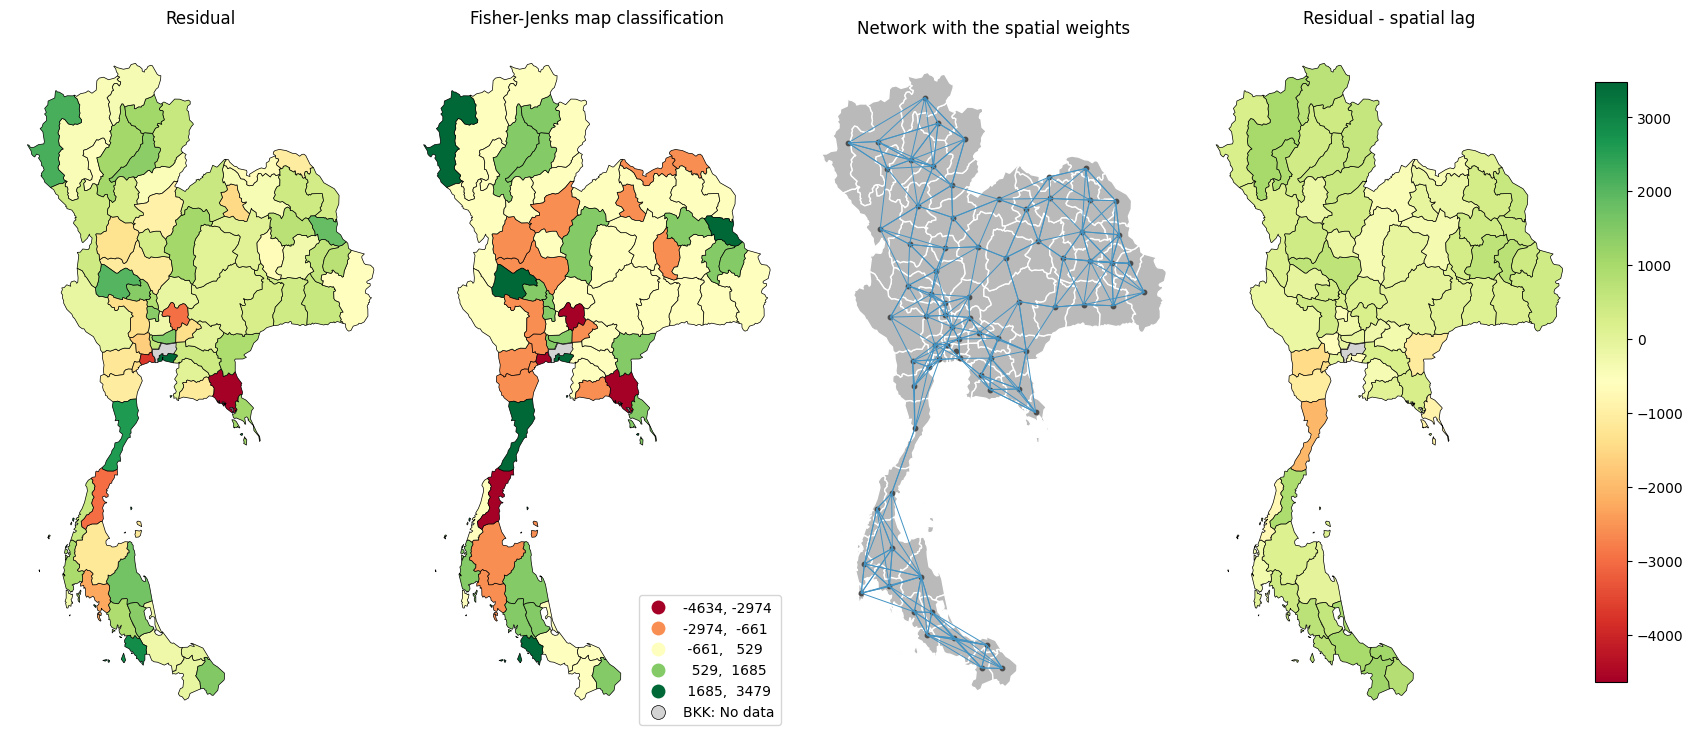

In [18]:
vmin = ThailandMap[['Residual', 'ResidualSpatialLag']].min().min()
vmax = ThailandMap[['Residual', 'ResidualSpatialLag']].max().max()

f, ax = plt.subplots(1, 4, figsize=(16, 7.5), subplot_kw=dict(aspect="equal"))

# Choropleth of residuals
ThailandMap.plot(
    "Residual"
    , cmap = 'RdYlGn'
    , vmin = vmin
    , vmax = vmax
    , ax = ax[0]
    , edgecolor = 'k'
    , linewidth = 0.5
    , missing_kwds = {'color':'lightgrey'}
)
ax[0].set_title("Residual")

# Fisher-Jenks map classification
ThailandMap.plot(
    column="Residual",
    scheme="FisherJenks",
    cmap="RdYlGn",
    legend=True,
    legend_kwds={"fmt": "{:.0f}", "loc":'lower right'},
    edgecolor='k',
    linewidth=0.5,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'},
    ax=ax[1]
)
ax[1].set_title("Fisher-Jenks map classification")

# Network of spatial weights
plot_spatial_weights(
    WeightKnn,
    ThailandMap,
    figsize=(4,7.5),
    ax=ax[2]
)
ax[2].set_title("Network with the spatial weights")

# Choropleth of spatial lag
ThailandMap.plot(
    "ResidualSpatialLag"
    , cmap = 'RdYlGn'
    , vmin = vmin
    , vmax = vmax
    , ax = ax[3]
    , edgecolor = 'k'
    , linewidth = 0.5
    , missing_kwds = {'color':'lightgrey'}
)
ax[3].set_title("Residual - spatial lag")

# Remove axis
[ax_.set_axis_off() for ax_ in ax]

# Add the color bar
cbar = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb_ax = f.add_axes([1,0.1,0.02,0.8])
f.colorbar(cbar, cax=cb_ax, orientation="vertical")

# Tight layout to minimize in-between white space
f.tight_layout()

---

Calculate the global spatial autocorrelation, given by the Moran's I

In [19]:
moran = esda.moran.Moran(ThailandMapWithoutBkk['Residual'], WeightKnn)

In [20]:
moran.p_sim

0.391

Calculate the Local Indicator of Spatial Association (LISA), given by the local Moran's I

In [21]:
lisa = esda.moran.Moran_Local(ThailandMapWithoutBkk["Residual"], WeightKnn)

In [22]:
# Find out significant observations
SignificanceLocalMoranI = pd.Series(
    1 * (lisa.p_sim < ALPHA_LEVEL),  # Assign 1 if significant, 0 otherwise
    index=ThailandMapWithoutBkk.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})

In [23]:
ThailandMapWithoutBkk['LocalMoranI'] = lisa.Is
ThailandMapWithoutBkk['SignificanceLocalMoranI'] = SignificanceLocalMoranI

QuadrantDict = {1:'HH', 2:'LH', 3:'LL', 4:'HL'}
ThailandMapWithoutBkk['LisaQuadrant'] = lisa.q
ThailandMapWithoutBkk['LisaQuadrant'] = ThailandMapWithoutBkk['LisaQuadrant'].map(QuadrantDict)

ThailandMapWithoutBkk['MoranCluster'] = ThailandMapWithoutBkk['SignificanceLocalMoranI']
ThailandMapWithoutBkk.loc[ThailandMapWithoutBkk['SignificanceLocalMoranI']=='Significant', 'MoranCluster'] =ThailandMapWithoutBkk.loc[ThailandMapWithoutBkk['SignificanceLocalMoranI']=='Significant', 'LisaQuadrant']

Calculate the residuals center and its spatial lag

In [24]:
ThailandMapWithoutBkk['ResidualCenter'] = ThailandMapWithoutBkk['Residual'] - ThailandMapWithoutBkk['Residual'].mean()
ThailandMapWithoutBkk['ResidualCenterSpatialLag'] = lag_spatial(WeightKnn, ThailandMapWithoutBkk['ResidualCenter'])

In [25]:
ThailandMap = pd.merge(
    ThailandMap
    , ThailandMapWithoutBkk[['ProvinceId', 'ResidualCenter', 'ResidualCenterSpatialLag', 'LocalMoranI', 'SignificanceLocalMoranI', 'LisaQuadrant', 'MoranCluster']]
    , how='left'
)

---

In [26]:
my_colors_quadrant = [
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), # blue
    (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), # light blue
    (1.0, 0.596078431372549, 0.5882352941176471, 1.0), # light red
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0) # red
]

my_colors_significance = [
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), # dark grey
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0) # purple
]

my_colors_quadrant_significance = [
    #(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), # blue
    (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), # light blue
    (1.0, 0.596078431372549, 0.5882352941176471, 1.0), # light red
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), # red
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0) # dark grey
]

Text(0, 0.5, 'Residual - spatial lag')

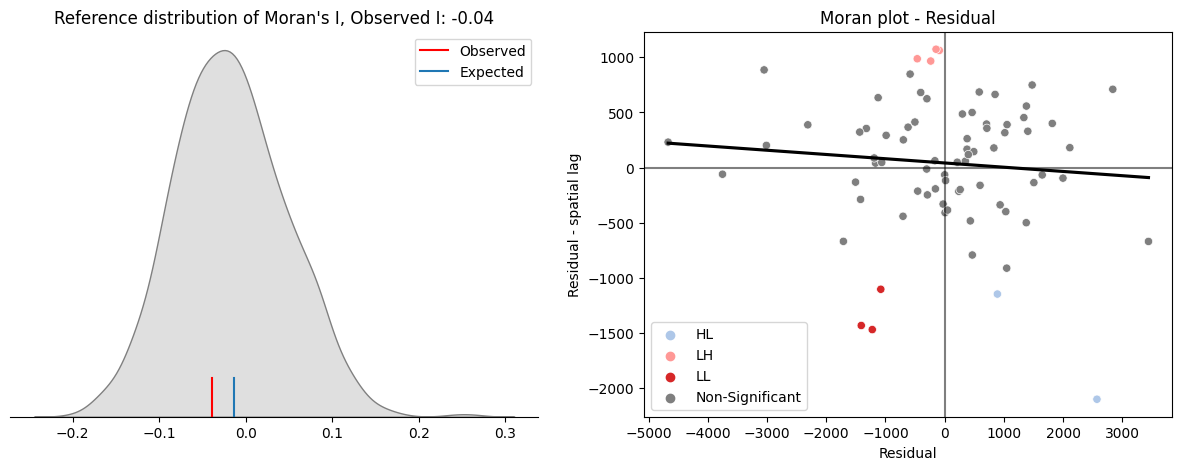

In [27]:
f, ax = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(moran.sim, fill=True, color='grey', ax=ax[0])
ax[0].axvline(x=moran.I, ymax=0.1, c='r', label='Observed')
ax[0].axvline(x=moran.EI, ymax=0.1, label='Expected')

ax[0].set_yticks([])
ax[0].set_ylabel("")
ax[0].set_title("Reference distribution of Moran's I, Observed I: {}".format(round(moran.I,2)))
ax[0].legend()

ax[0].spines[['left', 'right', 'top']].set_visible(False)

sns.scatterplot(
    data=ThailandMapWithoutBkk,
    x="ResidualCenter",
    y="ResidualCenterSpatialLag",
    hue="MoranCluster",
    ax=ax[1],
    hue_order=['HL', 'LH', 'LL', 'Non-Significant'],
    palette=sns.color_palette(my_colors_quadrant_significance, as_cmap=True),
)

sns.regplot(
    data=ThailandMapWithoutBkk,
    x="ResidualCenter",
    y="ResidualCenterSpatialLag",
    ci=None,
    scatter=False,
    line_kws={"color": "k"},
    ax=ax[1]
)

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles[0:], labels=labels[0:])

ax[1].axvline(0, c="k", alpha=0.5)
ax[1].axhline(0, c="k", alpha=0.5)
ax[1].set_title("Moran plot - Residual")

ax[1].set_xlabel("Residual")
ax[1].set_ylabel("Residual - spatial lag")

/tmp/ipykernel_12622/1557944096.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


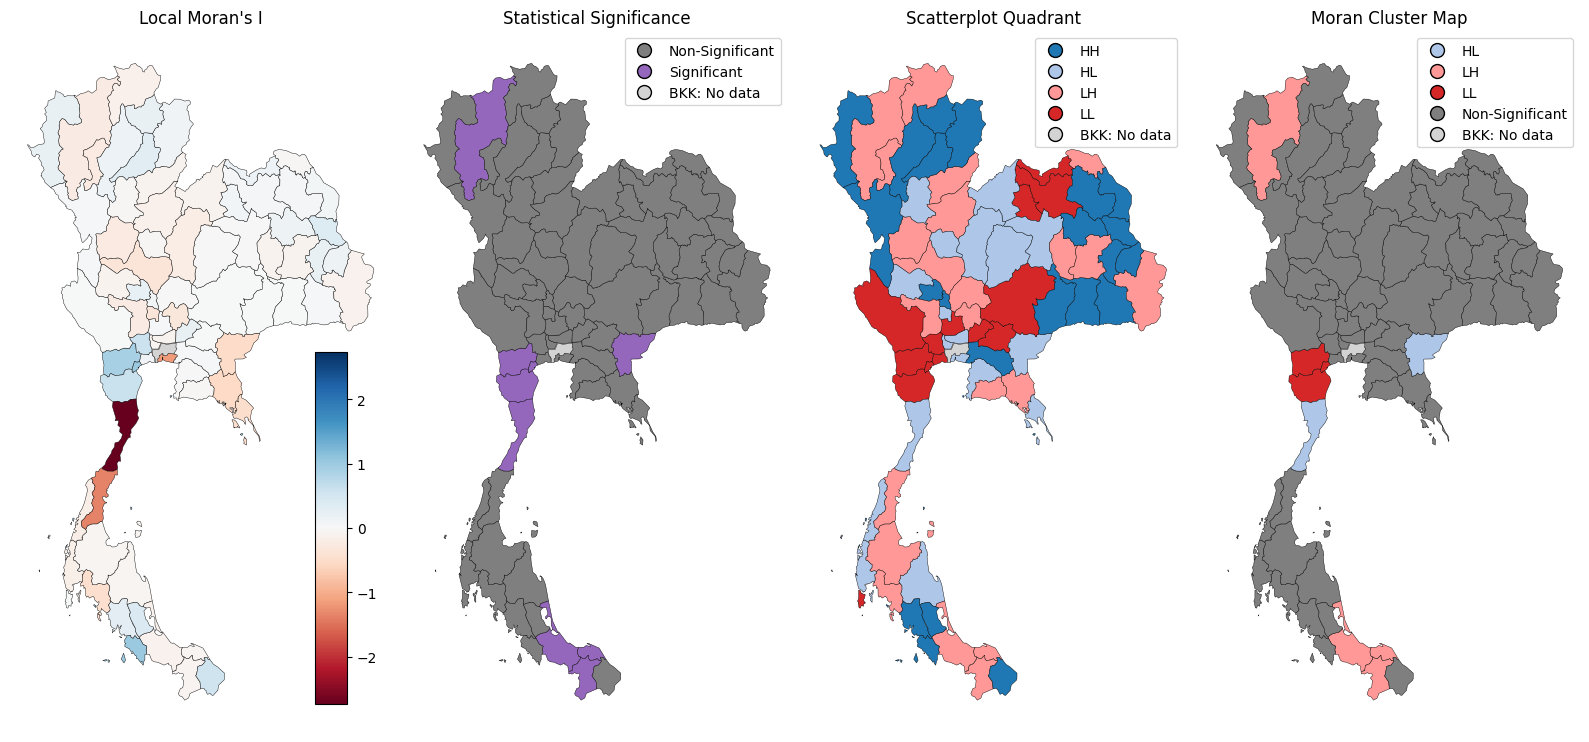

In [28]:
vmax = np.max([np.abs(ThailandMap['LocalMoranI'].min()), np.abs(ThailandMap['LocalMoranI'].max())])
vmin = -vmax

f, axs = plt.subplots(1, 4, figsize=(16, 7.5))

# Choropleth of local statistics
ThailandMap.plot(
    column="LocalMoranI",
    vmin=vmin,
    vmax=vmax,
    cmap="RdBu",
    ax=axs[0],
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Significance map
ThailandMap.plot(
    column="SignificanceLocalMoranI",
    cmap=LinearSegmentedColormap.from_list('my_cmap', colors=my_colors_significance),
    categorical=True,
    legend=True,
    ax=axs[1],
    legend_kwds={"loc":'upper right'},
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Quadrant categories
ThailandMap.plot(
    column="LisaQuadrant",
    cmap=LinearSegmentedColormap.from_list('my_cmap', colors=my_colors_quadrant),
    categorical=True,
    legend=True,
    ax=axs[2],
    legend_kwds={"loc":'upper right'},
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Cluster map
ThailandMap.plot(
    column="MoranCluster",
    cmap=LinearSegmentedColormap.from_list('my_cmap', colors=my_colors_quadrant_significance),
    categorical=True,
    legend=True,
    ax=axs[3],
    legend_kwds={"loc":'upper right'},
    edgecolor='k',
    linewidth=0.3,
    missing_kwds={'color':'lightgrey', 'label':'BKK: No data'}
).set_axis_off()

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Moran's I",
            "Statistical Significance",
            "Scatterplot Quadrant",
            "Moran Cluster Map",
        ][i],
        y=1,
    )

    if i > 0:
        for legend_handle in ax.get_legend().legend_handles:
                legend_handle.set_markeredgewidth(1)
                legend_handle.set_markeredgecolor('k')

# Add the color bar
cbar = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb_ax = f.add_axes([0.2,0.07,0.02,0.47])
f.colorbar(cbar, cax=cb_ax, orientation="vertical")

# Tight layout to minimize in-between white space
f.tight_layout()